In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [2]:
# image processing with pytorhc notebook

mean = [0.49159095, 0.48234567, 0.4467194 ]
std = [0.23834856, 0.23494388, 0.25271425]

In [3]:
train_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
test_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [5]:
trainset = torchvision.datasets.CIFAR10(root='../datasets/cifar10/train',
                                       train=True,
                                       download=True,
                                       transform=train_transform)

Files already downloaded and verified


In [6]:
testset = torchvision.datasets.CIFAR10(root='../datasets/cifar10/train',
                                       train=False,
                                       download=True,
                                       transform=test_transform)

Files already downloaded and verified


In [7]:
trainloader = torch.utils.data.DataLoader(trainset,
                                         batch_size=16,
                                         shuffle=True,
                                         num_workers=2)

In [8]:
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=16,
                                         shuffle=False,
                                         num_workers=2)

In [9]:
class_names = trainset.classes

print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [10]:
image_batch, labels = iter(trainloader).next()

In [11]:
# 16 images in batch, each image is multi-channel (RGB) with 32px height and 32px width
# 16 labels correspond to 16 images

image_batch.shape, labels.shape

(torch.Size([16, 3, 32, 32]), torch.Size([16]))

In [12]:
labels

tensor([0, 6, 4, 7, 0, 4, 0, 1, 7, 2, 9, 3, 8, 3, 2, 8])

In [13]:
def get_text_label(index):
    return trainset.classes[index]

In [14]:
get_text_label(0)

'airplane'

In [15]:
in_size = 3 # 3 channels

# 2 convolutional layers

# first layer generates 16 feature maps
hid1_size = 16 

# second layer generates 32 feature maps
hid2_size = 32


# 2 linear layers

# Layer 1: 32 x 32 => 28 x 28 => pooling => 14 x 14
# Layer 2: 14 x 14 => 10 x 10 => pooling => 5 x 5
# 32 x 5 x 5 = 800

# first
out1_size = 400

# second layer correspond to 10 classes: trainset.classes
out2_size = 10

# 5x5 kernel
k_conv_size = 5

In [16]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_size, hid1_size, k_conv_size), # 28 x 28
            nn.BatchNorm2d(hid1_size),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)) # 14 x 14
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(hid1_size, hid2_size, k_conv_size), # 10 x 10
            nn.BatchNorm2d(hid2_size),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)) # 5 x 5
        
        self.layer3 = nn.Sequential(
            nn.Linear(hid2_size * k_conv_size * k_conv_size, out1_size),
            nn.Tanh(),
            # randomly turn of certain neurons,
            # forcing other neurons to learn significant features
            # mitigate neural network overfitting
            nn.Dropout(0.5), # 800 x 0.5 = 400 = out1_size
            nn.Linear(out1_size, out2_size))
        
        
    def forward(self, x):
        
        out = self.layer1(x) 
        out = self.layer2(out) 
        
        out = out.reshape(out.size(0), -1)
        
        out = self.layer3(out)
        
        return F.log_softmax(out, dim=-1)
        

In [17]:
model = ConvNet()

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cpu


In [19]:
learning_rate = 0.001 

criterion = nn.NLLLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
total_step = len(trainloader)
num_epochs = 20 
loss_values = list()

In [21]:
for epoch in range(num_epochs):
    
    # loop over every image in batch
    for i, (images, labels) in enumerate(trainloader):
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 2000 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss {:.4f}'
                .format(epoch + 1, num_epochs, i+1, total_step, loss.item()))
            
            loss_values.append(loss.item())
            
print('Finished Training')

Epoch [1/20], Step [2000/3125], Loss 1.7444
Epoch [2/20], Step [2000/3125], Loss 1.1501
Epoch [3/20], Step [2000/3125], Loss 0.9494
Epoch [4/20], Step [2000/3125], Loss 0.8215
Epoch [5/20], Step [2000/3125], Loss 1.2074
Epoch [6/20], Step [2000/3125], Loss 1.1584
Epoch [7/20], Step [2000/3125], Loss 0.6334
Epoch [8/20], Step [2000/3125], Loss 0.5676
Epoch [9/20], Step [2000/3125], Loss 0.9184
Epoch [10/20], Step [2000/3125], Loss 1.0898
Epoch [11/20], Step [2000/3125], Loss 1.1774
Epoch [12/20], Step [2000/3125], Loss 1.5859
Epoch [13/20], Step [2000/3125], Loss 0.9992
Epoch [14/20], Step [2000/3125], Loss 0.9929
Epoch [15/20], Step [2000/3125], Loss 0.5802
Epoch [16/20], Step [2000/3125], Loss 0.9769
Epoch [17/20], Step [2000/3125], Loss 0.8932
Epoch [18/20], Step [2000/3125], Loss 0.8038
Epoch [19/20], Step [2000/3125], Loss 0.5998
Epoch [20/20], Step [2000/3125], Loss 1.0423
Finished Training


Text(0, 0.5, 'Loss')

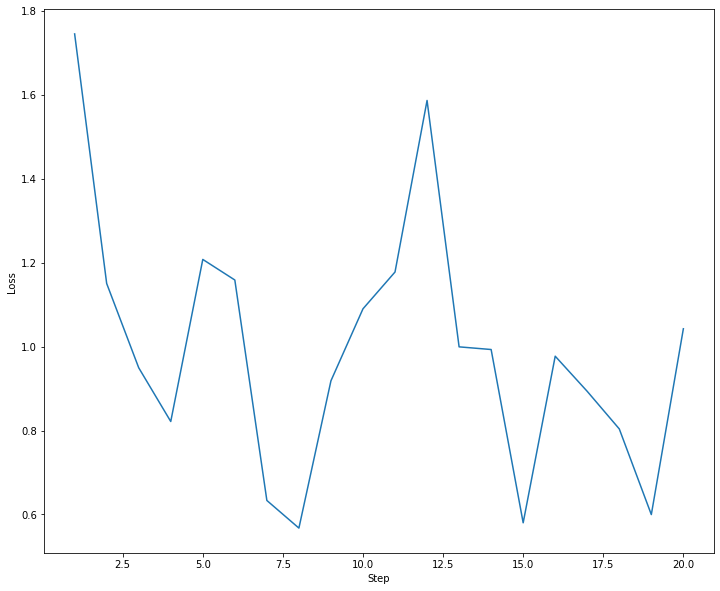

In [22]:
x = (range(1, num_epochs+1))

plt.figure(figsize=(12, 10))

plt.plot(x, loss_values)
plt.xlabel('Step')
plt.ylabel('Loss')

In [23]:
model.eval()

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=800, out_features=400, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=400, out_features=10, bias=True)
  )
)

In [24]:
with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in testloader:
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Accuracy of the model on 10000 test images: {}%'
             .format(100 * correct / total))

Accuracy of the model on 10000 test images: 71.16%


In [25]:
sample_images, sample_labels = testset[23]

In [26]:
sample_images.shape

torch.Size([3, 32, 32])

In [27]:
sample_image = np.transpose(sample_images, (1, 2, 0))
sample_image.shape

torch.Size([32, 32, 3])

In [28]:
m, M = sample_image.min(), sample_image.max()

In [29]:
sample_image = (1/(abs(m) * M)) * sample_image + 0.5

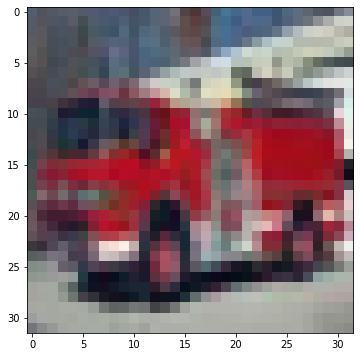

In [30]:
plt.figure(figsize=(6,6))
plt.imshow(sample_image)

In [31]:
test_img, test_label = testset[23]

test_img = test_img.reshape(-1, 3, 32, 32)

In [32]:
out_predicted = model(test_img)
_, predicted = torch.max(out_predicted.data, 1)

In [33]:
print('Actual label: ', get_text_label(test_label))

Actual label:  truck


In [34]:
print('Predicted label: ', get_text_label(predicted.item()))

Predicted label:  truck
